# 1 parameter IBP

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy as sp
from scipy.io import mmread
import mpmath as mp
from scipy.optimize import minimize
%matplotlib inline

In [98]:
N = 100
alpha = 1

k1 = int(np.random.poisson(alpha, 1))
Z = np.zeros((N, k1))
Z[0, :] = 1 #the first k1 dishes

for n in range(1, N):
  for d in range(Z.shape[1]):  # number of columns/dishes
     p = np.random.uniform(0, 1, 1)
     m = sum(Z[:, d])
     if p < m/n:
        Z[n, d] = 1
  k2 = np.random.poisson(alpha/n)
  Z2 = np.zeros((N, k2))
  Z2[n,:] = 1
  Z = np.concatenate((Z, Z2), axis=1)

# 2 parameter IBP

In [102]:
N = 100
beta = 1
alpha = 1

k1 = int(np.random.poisson(alpha, 1))
Z = np.zeros((N, k1))
Z[0, :] = 1 #the first k1 dishes

for n in range(1, N):
  for d in range(Z.shape[1]):  # number of columns/dishes
     p = np.random.uniform(0, 1, 1)
     m = sum(Z[:, d])
     if p < m/(beta + n -1):
        Z[n, d] = 1
  k2 = np.random.poisson((alpha*beta)/(beta + n -1))
  Z2 = np.zeros((N, k2))
  Z2[n,:] = 1
  Z = np.concatenate((Z, Z2), axis=1)

# 3 parameter IBP

In [119]:
N=10
c = 1
sigma = 0.8
alpha = 1

k1 = int(np.random.poisson(alpha, 1))
Z = np.zeros((N, k1))
Z[0, :] = 1 #the first k1 dishes

for n in range(1, N):
  for d in range(Z.shape[1]):  # number of columns/dishes
     p = np.random.uniform(0, 1, 1)
     m = sum(Z[:, d])
     if p < (m - sigma) / (c + n - 1):
        Z[n, d] = 1
  k2 = np.random.poisson((alpha * mp.gamma(1 + c) * mp.gamma(n - 1 + c + sigma)) / (mp.gamma(n + c) * mp.gamma(c + sigma)))
  Z2 = np.zeros((N, k2))
  Z2[n,:] = 1
  Z = np.concatenate((Z, Z2), axis=1)


In [ ]:
Z.shape[1] #number of dishes tried given by the number of (non-zero) columns

In [120]:
def ibp_3param(N, sigma, c=1, alpha=1):
    k1 = int(np.random.poisson(alpha, 1))
    Z = np.zeros((N, k1))
    Z[0, :] = 1 #the first k1 dishes
    for n in range(1, N):
        for d in range(Z.shape[1]):  # number of columns/dishes
            p = np.random.uniform(0, 1, 1)
            m = sum(Z[:, d])
            if p < (m - sigma) / (c + n - 1):
                Z[n, d] = 1
        k2 = np.random.poisson((alpha * mp.gamma(1 + c) * mp.gamma(n - 1 + c + sigma)) / (mp.gamma(n + c) * mp.gamma(c + sigma)))
        Z2 = np.zeros((N, k2))
        Z2[n,:] = 1
        Z = np.concatenate((Z, Z2), axis=1)
    return(Z)

In [163]:
def stableibprnd(alpha, sigma, c, N):
    Jmax = 3000; 
    Z = np.zeros((N, Jmax))
    m = np.zeros(Jmax) # col sums

    # First object

    K = int(np.random.poisson(alpha, 1))
    #print(K)
    Z[0, range(K)] = 1
    m[range(K)] = 1
    for n in range(1, N):
        # Each object picks feature j w.p. (m_j-sigma)/(i-1 + c)
        Z[n, range(K)] = ( np.random.uniform(0, 1, K) < ((m[range(K)]-sigma)/(n  + c)) )
        # New features 
        Knew = np.random.poisson((alpha * mp.gamma(1 + c) * mp.gamma(n + c + sigma)) / (mp.gamma(n + 1 + c) * mp.gamma(c + sigma)))
        if Knew>0:
            Z[n, range(K,K+Knew)] = 1
            m[range(K,K+Knew)] = 1  
        # Update the counts
        m[range(K)] = m[range(K)]  + Z[n, range(K)]
        #print(Knew)
          
        K = K + Knew   
    Z = Z[:, range(K)]
    return(Z)

In [158]:
alpha=1
sigma=0.5
c=1

sum([(alpha * mp.gamma(1 + c) * mp.gamma(n + c + sigma)) / (mp.gamma(n + 1 + c) * mp.gamma(c + sigma)) for n in range(1,1000000)])

mpf('2253.7591804753251')

# Figure 1b

In [ ]:
unique_elements, counts

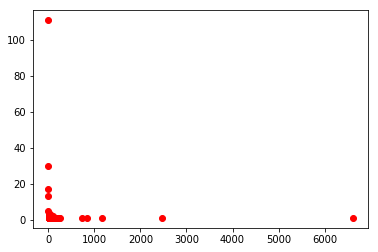

In [139]:
# linear scale, N = 10000

Z = ibp_3param(N = 10000, sigma = 0.5, c = 1, alpha = 1)
a = Z.sum(axis=0)
unique_elements, counts = np.unique(a, return_counts=True)
plt.plot(unique_elements, counts, "ro")

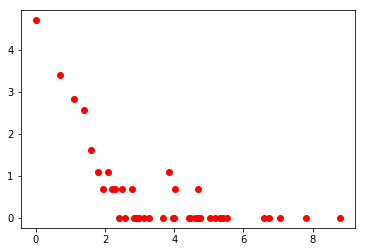

In [140]:
# log log scale, N = 10000

plt.plot(np.log(unique_elements), np.log(counts), "ro")

Text(0,0.5,'Frequency of dishes')

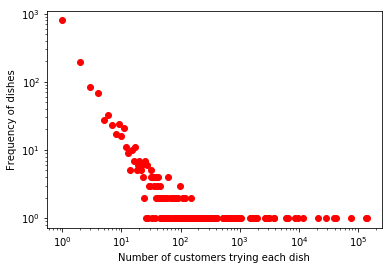

In [165]:
# linear scale, N = 1000000

Z2 = stableibprnd(N = 500000, sigma = 0.5, c = 1, alpha = 1)
a2 = Z2.sum(axis=0)
unique_elements2, counts2 = np.unique(a2, return_counts=True)
plt.plot(unique_elements2, counts2, "ro")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Number of customers trying each dish")
plt.ylabel("Frequency of dishes")

# More efficient IBP function

In [166]:
from scipy.sparse import csr_matrix

def csr_vappend(a,b):
    """ Takes in 2 csr_matrices and appends the second one to the bottom of the first one. 
    Much faster than scipy.sparse.vstack but assumes the type to be csr and overwrites
    the first matrix instead of copying it. The data, indices, and indptr still get copied."""

    a.data = np.hstack((a.data,b.data))
    a.indices = np.hstack((a.indices,b.indices))
    a.indptr = np.hstack((a.indptr,(b.indptr + a.nnz)[1:]))
    a._shape = (a.shape[0]+b.shape[0],b.shape[1])
    return(a)
	

def stableibprnd(alpha, sigma, c, N, Jmax):
    Z = np.zeros((1, Jmax))
    m = np.zeros(Jmax) # col sums

    # First object
    
    K = int(np.random.poisson(alpha, 1))
    #print(K)
    Z[0, range(K)] = 1
    Z = csr_matrix(Z)
    m[range(K)] = 1
    for n in range(1, N):
        vec = np.zeros((1, Jmax))
        # Each object picks feature j w.p. (m_j-sigma)/(i-1 + c)
        vec[0,range(K)] = ( np.random.uniform(0, 1, K) < ((m[range(K)]-sigma)/(n  + c)) )
        # New features
        Knew = np.random.poisson((alpha * mp.gamma(1 + c) * mp.gamma(n + c + sigma)) / (mp.gamma(n + 1 + c) * mp.gamma(c + sigma)))
        if Knew>0:
            vec[0, range(K,K+Knew)] = 1
            m[range(K,K+Knew)] = 1
    # Update the counts
        m[range(K)] = m[range(K)]  + vec[0, range(K)]
        #print(Knew)

        K = K + Knew
        if n % 500 ==0:
            print(n)
        vec = csr_matrix(vec)
        csr_vappend(Z, vec)
    return(Z)

In [167]:
Z3 = stableibprnd(N = 500000, sigma = 0.5, c = 1, alpha = 1, Jmax=100000)
a2 = Z3.sum(axis=0)
unique_elements2, counts2 = np.unique(a2, return_counts=True)
plt.plot(unique_elements2, counts2, "ro")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Number of customers trying each dish")
plt.ylabel("Frequency of dishes")

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
77000
77500
78000
78500
79000
79500
80000
80500
81000
81500
82000
82500
83000
83500
84000
84500
85000


ValueError: all the input arrays must have same number of dimensions

Text(0,0.5,'Frequency of dishes')

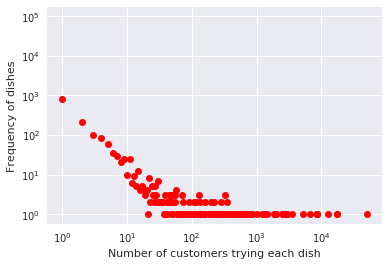

In [175]:
sns.set()

a = np.squeeze(np.asarray(a2))
unique_elements2, counts2 = np.unique(a, return_counts=True)
plt.plot(unique_elements2, counts2, "ro")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Number of customers trying each dish")
plt.ylabel("Frequency of dishes")